# 02 · Baseline: TF-IDF + Linear

**Цель.** Базовое супервизируемое решение для coarse-классификации: быстро получить отправную точку по качеству и латентности.

**Что делаем**

- Препроцессинг текста (нормализация, минимальная очистка).
    
- TF-IDF (слова/символьные n-граммы; ru stopwords).
    
- Линейная модель (LogReg/LinearSVC), стратиф. CV.
    
- Метрики: accuracy, macro/micro-F1, confusion по топ-классам.
    
- Экспорт артефактов бейслайна (по желанию).
    

**Зачем нужно**

- Отправная точка для сравнения с RuBERT.
    
- Быстрые эксперименты по признакам/балансу классов.
    

## Импорты и пути

In [2]:

from pathlib import Path
import re, json, datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import joblib

# Пути к данным и артефактам
DATA_PATH = Path("../data/synthetic_ru_private_ads_50cats_10000_v2.csv")
MODEL_PATH = Path("../data/supervised_baseline.joblib")
REPORT_PATH = Path("../data/supervised_eval_report.csv")
PRED_SAMPLES_PATH = Path("../data/supervised_pred_samples.csv")

assert DATA_PATH.exists(), f"Не найден датасет: {DATA_PATH}"


## Загрузка данных

In [3]:

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)


(10000, 10)


,id,title,description,category,condition,city,price,currency,posted_at,source
0,fd6c2aae-a67c-4d0a-8aca-468114fdd2bc,Продаю автоаксессуары — Санкт-Петербург,Покажу сегодня. Без дтп. Документы в наличии. ...,Автоаксессуары,удовлетворительное,Санкт-Петербург,62854,RUB,2025-03-27T17:16:19,synthetic_ru_private_ads_v2
1,1de380f2-85b5-44c9-96d5-a923c29737b5,Продаю автоаксессуары — Казань,Город: Воронеж. Договорная. Обслуживание у дил...,Автоаксессуары,на запчасти,Уфа,83030,RUB,2025-04-24T16:42:19,synthetic_ru_private_ads_v2
2,1646a31d-943e-4510-a3f5-57417f3a23db,В продаже автоаксессуары — Нижний Новгород,Гаражное хранение. Город: Новосибирск. Покажу ...,Автоаксессуары,новое,Хабаровск,70628,RUB,2025-08-02T18:05:19,synthetic_ru_private_ads_v2



## Очистка текста (склейка title+description, удаление телефонов и городов)

- Склеиваем `title` + `description`.
- Удаляем телефоноподобные последовательности.
- Удаляем встречающиеся в колонке `city` города (чтобы не переобучаться на географию).


In [4]:

text_col1, text_col2 = "title", "description"
label_col = "category"

cities = sorted(df["city"].dropna().astype(str).unique().tolist()) if "city" in df.columns else []
phone_pattern = re.compile(r"(\+?\d[\d\-\s]{6,}\d)")
multi_space = re.compile(r"\s+")
city_pattern = re.compile(r"\b(" + "|".join([re.escape(c) for c in cities]) + r")\b", flags=re.IGNORECASE) if cities else None

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = phone_pattern.sub(" ", s)
    if city_pattern is not None:
        s = city_pattern.sub(" ", s)
    s = multi_space.sub(" ", s).strip()
    return s

df["_text"] = (df[text_col1].fillna("") + " " + df[text_col2].fillna("")).apply(clean_text)
df[label_col] = df[label_col].astype(str)
df = df[df["_text"].str.len() > 0].copy()

print("Пример очищенного текста:")
display(df[["_text", label_col]].head(3))


Пример очищенного текста:


,_text,category
0,продаю автоаксессуары — покажу сегодня. без дт...,Автоаксессуары
1,продаю автоаксессуары — город: . договорная. о...,Автоаксессуары
2,в продаже автоаксессуары — гаражное хранение. ...,Автоаксессуары


## Тренировочное и тестовое разбиение

In [5]:

X = df["_text"].values
y = df[label_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test), len(np.unique(y))


(8000, 2000, 50)

## Признаки: TF‑IDF по словам и символам

In [6]:

word_vect = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 2),
    min_df=2, max_df=0.95, sublinear_tf=True
)
char_vect = TfidfVectorizer(
    analyzer="char", ngram_range=(3, 5),
    min_df=2, sublinear_tf=True
)

X_train_all = hstack([word_vect.fit_transform(X_train), char_vect.fit_transform(X_train)]).tocsr()
X_test_all  = hstack([word_vect.transform(X_test),    char_vect.transform(X_test)]).tocsr()

X_train_all.shape, X_test_all.shape


((8000, 17678), (2000, 17678))

## Обучение классификатора (LinearSVC + калибровка вероятностей)

In [7]:

clf = CalibratedClassifierCV(LinearSVC(), method="sigmoid", cv=3)
clf.fit(X_train_all, y_train)

proba = clf.predict_proba(X_test_all)
pred  = clf.classes_[proba.argmax(1)]


## Базовые метрики качества

In [8]:

acc = accuracy_score(y_test, pred)
macro_f1 = f1_score(y_test, pred, average="macro")
print(f"Accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f}")
print("\nКлассификационный отчет (срез):")
print(classification_report(y_test, pred)[:1000])  # укоротим вывод


Accuracy: 1.0000 | Macro-F1: 1.0000

Классификационный отчёт (срез):
                           precision    recall  f1-score   support

           Автоаксессуары       1.00      1.00      1.00        40
             Аудиотехника       1.00      1.00      1.00        40
               Велосипеды       1.00      1.00      1.00        40
         Водный транспорт       1.00      1.00      1.00        40
        Гаражи и парковки       1.00      1.00      1.00        40
  Грузовики и спецтехника       1.00      1.00      1.00        40
           Детская одежда       1.00      1.00      1.00        40
     Дома и дачи — аренда       1.00      1.00      1.00        40
    Дома и дачи — продажа       1.00      1.00      1.00        40
        Запчасти для авто       1.00      1.00      1.00        40
                  Игрушки       1.00      1.00      1.00        40
         Игры и приставки       1.00      1.00      1.00        40
              Инструменты       1.00      1.00      1.00   

## Матрица ошибок (без класса "Other")

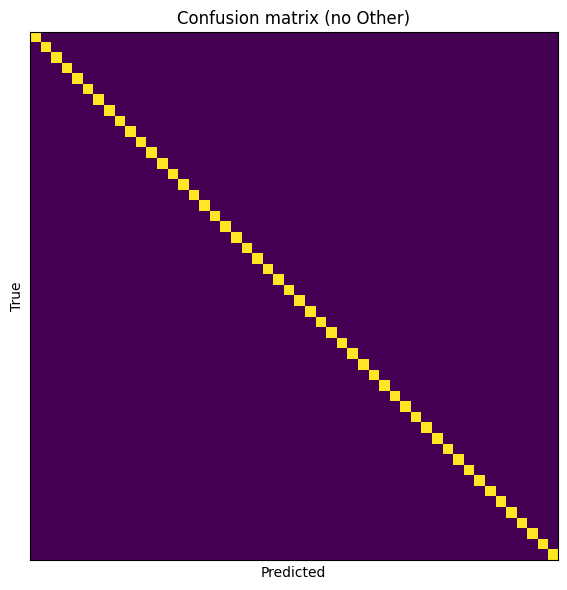

In [9]:

cm = confusion_matrix(y_test, pred, labels=clf.classes_)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix (no Other)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.show()


## Подбор порога для класса "Other"

In [10]:

def evaluate_with_other(y_true, proba, classes, tau: float):
    idx = np.argmax(proba, axis=1)
    maxp = proba[np.arange(len(y_true)), idx]
    y_hat = classes[idx].astype(object)
    y_hat[maxp < tau] = "Other"
    labels = list(np.unique(list(y_true) + ["Other"]))
    f1 = f1_score(y_true, y_hat, labels=labels, average="macro")
    return f1, y_hat, maxp

taus = np.linspace(0.50, 0.95, 10)
best_tau, best_f1 = None, -1.0
for t in taus:
    f1_t, _, _ = evaluate_with_other(y_test, proba, clf.classes_, t)
    if f1_t > best_f1:
        best_f1, best_tau = f1_t, t

print(f"Best tau: {best_tau:.3f} | Macro-F1 with Other: {best_f1:.4f}")


Best tau: 0.500 | Macro-F1 with Other: 0.9804


/Users/maxim/Documents/GitHub/report-analysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/maxim/Documents/GitHub/report-analysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/maxim/Documents/GitHub/report-analysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parame

## Сохранение артефактов (vectorizers + model + порог)

In [11]:

joblib.dump({
    "word_vect": word_vect,
    "char_vect": char_vect,
    "clf": clf,
    "reject": {"strategy": "probability", "tau": float(best_tau)},
    "text_cols": [text_col1, text_col2],
    "label_col": label_col,
    "city_stoplist": cities,
}, MODEL_PATH)

# Небольшой отчет и примеры
maxp = proba.max(1)
pred_with_other = pred.astype(object)
pred_with_other[maxp < best_tau] = "Other"

pd.DataFrame({
    "accuracy": [acc],
    "macro_f1": [macro_f1],
    "best_tau": [best_tau],
    "macro_f1_with_other": [best_f1]
}).to_csv(REPORT_PATH, index=False)

pd.DataFrame({
    "text": X_test[:50],
    "true_label": y_test[:50],
    "pred_label": pred[:50],
    "pred_with_other": pred_with_other[:50],
    "confidence": maxp[:50].round(3),
}).to_csv(PRED_SAMPLES_PATH, index=False)

print("Сохранено:")
print("-", MODEL_PATH)
print("-", REPORT_PATH)
print("-", PRED_SAMPLES_PATH)


Сохранено:
- ../data/supervised_baseline.joblib
- ../data/supervised_eval_report.csv
- ../data/supervised_pred_samples.csv


## Инференс: функции загрузки и предсказания

In [12]:

def load_artifacts(model_path=MODEL_PATH):
    arts = joblib.load(model_path)
    return arts

def _build_cleaner(city_stoplist):
    phone_pattern = re.compile(r"(\+?\d[\d\-\s]{6,}\d)")
    multi_space = re.compile(r"\s+")
    city_pattern = re.compile(r"\b(" + "|".join([re.escape(c) for c in city_stoplist]) + r")\b", flags=re.IGNORECASE) if city_stoplist else None
    def clean_text(s: str) -> str:
        s = str(s).lower()
        s = phone_pattern.sub(" ", s)
        if city_pattern is not None:
            s = city_pattern.sub(" ", s)
        s = multi_space.sub(" ", s).strip()
        return s
    return clean_text

def classify_texts(texts, arts=None, use_other=True, topk=5):
    if arts is None:
        arts = load_artifacts()
    word_vect = arts["word_vect"]
    char_vect = arts["char_vect"]
    clf = arts["clf"]
    tau = float(arts["reject"]["tau"]) if use_other else 0.0
    text_cols = arts.get("text_cols", ["title", "description"])
    city_stoplist = arts.get("city_stoplist", [])

    clean = _build_cleaner(city_stoplist)

    # Нормализуем входы
    texts_clean = [clean(t) for t in texts]

    # Векторизация
    Xw = word_vect.transform(texts_clean)
    Xc = char_vect.transform(texts_clean)
    X = hstack([Xw, Xc]).tocsr()

    # Предсказания
    proba = clf.predict_proba(X)
    idx = np.argmax(proba, axis=1)
    preds = clf.classes_[idx]
    maxp = proba[np.arange(len(texts)), idx]

    # Применяем класс "Other" при необходимости
    preds_final = preds.astype(object)
    preds_final[maxp < tau] = "Other"

    # Топ-k кандидатов для каждой записи
    topk = int(topk)
    results = []
    for i in range(len(texts)):
        order = np.argsort(-proba[i])[:topk]
        results.append({
            "text": texts[i],
            "pred": preds_final[i],
            "confidence": float(maxp[i]),
            "topk_labels": clf.classes_[order].tolist(),
            "topk_scores": [float(proba[i, j]) for j in order],
        })
    return results


## Быстрый пример инференса (без виджетов)

In [13]:

samples = [
    "Продам ноутбук Lenovo i5 8GB 256GB SSD, состояние отличное",
    "Шлифовка стен, укладка плитки и стяжка пола — работаем по договору",
    "Есть в наличии книги, переплет твердый, издательство АСТ",
    "Продаю запчасти для авто, оригинал OEM, подходят на Kia/Hyundai",
    "Продаю авто, оригинал OEM, подходят на Kia/Hyundai",
]

res = classify_texts(samples, use_other=True, topk=5)
pd.DataFrame([{
    "text": r["text"],
    "pred": r["pred"],
    "confidence": round(r["confidence"], 3),
    "top1..5": list(zip(r["topk_labels"], [round(s,3) for s in r["topk_scores"]]))
} for r in res])


,text,pred,confidence,top1..5
0,"Продам ноутбук Lenovo i5 8GB 256GB SSD, состоя...",Ноутбуки,0.980,"[(Ноутбуки, 0.98), (Квартиры — продажа, 0.001)..."
1,"Шлифовка стен, укладка плитки и стяжка пола — ...",Other,0.285,"[(Ремонт и стройматериалы, 0.285), (Услуги рем..."
2,"Есть в наличии книги, переплёт твёрдый, издате...",Книги,0.978,"[(Книги, 0.978), (Квартиры — продажа, 0.001), ..."
3,"Продаю запчасти для авто, оригинал OEM, подход...",Запчасти для авто,0.979,"[(Запчасти для авто, 0.979), (Дома и дачи — пр..."
4,"Продаю авто, оригинал OEM, подходят на Kia/Hyu...",Other,0.453,"[(Запчасти для авто, 0.453), (Шины и диски, 0...."


## Интерактивный виджет: ввод текста -> предсказание категории

In [14]:

import ipywidgets as W
from IPython.display import display, HTML, clear_output

EXAMPLES = {
    "— выберите пример —": "",
    "Ноутбук": "Продам ноутбук Lenovo i5 8GB 256GB SSD, состояние отличное",
    "Ремонт": "Шлифовка стен, укладка плитки и стяжка пола — работаем по договору",
    "Книги": "Есть в наличии книги, переплет твердый, издательство АСТ",
    "Запчасти": "Продаю запчасти для авто, оригинал OEM, подходят на Kia/Hyundai",
    "Автомобиль": "Продаю автомобиль 2022 года без пробега, АКПП, ПТС на руках",
}

dd_example = W.Dropdown(options=list(EXAMPLES.keys()), description="Пример:", layout=W.Layout(width="50%"))
ta_input   = W.Textarea(value="", placeholder="Вставьте текст объявления..", description="Текст:", layout=W.Layout(width="100%", height="120px"))
chk_other  = W.Checkbox(value=True, description="Включить класс "Other"")
sp_topk    = W.IntSlider(value=5, min=1, max=10, step=1, description="Top‑K:")
btn_predict = W.Button(description="Определить категорию", button_style="primary", icon="search")
out = W.Output()

arts = load_artifacts()

def on_example_change(change):
    if change["type"] == "change" and change["name"] == "value":
        ta_input.value = EXAMPLES.get(change["new"], "")

dd_example.observe(on_example_change)

def format_result(r):
    tops = "".join([f"<li>{lab} — {score:.3f}</li>" for lab, score in zip(r['topk_labels'], r['topk_scores'])])
    html = f'''
    <div style="font-family: ui-sans-serif, system-ui; border:1px solid #e5e7eb; border-radius:12px; padding:14px;">
      <div style="font-size:16px; font-weight:600; margin-bottom:6px;">Результат</div>
      <div><b>Категория:</b> {r["pred"]}</div>
      <div><b>Уверенность:</b> {r["confidence"]:.3f}</div>
      <div style="margin:8px 0 4px;"><b>Top‑K кандидатов:</b></div>
      <ol style="margin-top:0;">{tops}</ol>
      <hr style="border:0; border-top:1px solid #e5e7eb; margin:12px 0;">
      <div style="opacity:.85"><b>Текст:</b> {r["text"]}</div>
    </div>'''
    return HTML(html)

def on_predict_clicked(_):
    with out:
        clear_output()
        text = ta_input.value.strip()
        if not text:
            display(HTML("<b>Введите текст объявления.</b>"))
            return
        btn_predict.description = "Считаю.."; btn_predict.disabled = True
        results = classify_texts([text], arts=arts, use_other=chk_other.value, topk=sp_topk.value)
        display(format_result(results[0]))
        btn_predict.description = "Определить категорию"; btn_predict.disabled = False

btn_predict.on_click(on_predict_clicked)

display(W.VBox([
    W.HBox([dd_example]),
    ta_input,
    W.HBox([chk_other, sp_topk]),
    btn_predict,
    out
]))


## Итоги (02 · Baseline)

- Построен устойчивый baseline (TF-IDF + Linear) с разумной латентностью.
    
- Выявлены пограничные пары классов (полезны для хард-негативов в CE и для саб-голов).
    
- Сформирована "нижняя планка" качества для дальнейших моделей.
    

**Дальше:**  
(1) сохранить confusion-матрицу и таблицу частых ошибок, (2) использовать ошибочные пары как **hard negatives** при обучении Cross-Encoder (см. A1 в appendix folder), (3) зафиксировать версию препроцессинга.